In [528]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

In [529]:
current_dir = os.getcwd()
path_file = os.path.join(current_dir, "datasets/defects_data.csv")
data = pd.read_csv(path_file, header=0)

In [530]:
data.head()

,defect_id,product_id,defect_type,defect_date,defect_location,severity,inspection_method,repair_cost
0,1,15,Structural,6/6/2024,Component,Minor,Visual Inspection,245.47
1,2,6,Functional,4/26/2024,Component,Minor,Visual Inspection,26.87
2,3,84,Structural,2/15/2024,Internal,Minor,Automated Testing,835.81
3,4,10,Functional,3/28/2024,Internal,Critical,Automated Testing,444.47
4,5,14,Cosmetic,4/26/2024,Component,Minor,Manual Testing,823.64


In [531]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   defect_id          1000 non-null   int64  
 1   product_id         1000 non-null   int64  
 2   defect_type        1000 non-null   object 
 3   defect_date        1000 non-null   object 
 4   defect_location    1000 non-null   object 
 5   severity           1000 non-null   object 
 6   inspection_method  1000 non-null   object 
 7   repair_cost        1000 non-null   float64
dtypes: float64(1), int64(2), object(5)
memory usage: 62.6+ KB


In [532]:
X = data[['defect_type', 'defect_location', 'inspection_method']]
y = data['severity']

In [533]:
X.head()

,defect_type,defect_location,inspection_method
0,Structural,Component,Visual Inspection
1,Functional,Component,Visual Inspection
2,Structural,Internal,Automated Testing
3,Functional,Internal,Automated Testing
4,Cosmetic,Component,Manual Testing


In [534]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   defect_type        1000 non-null   object
 1   defect_location    1000 non-null   object
 2   inspection_method  1000 non-null   object
dtypes: object(3)
memory usage: 23.6+ KB


In [535]:
y.head()

0       Minor
1       Minor
2       Minor
3    Critical
4       Minor
Name: severity, dtype: object

In [536]:
ohe = OneHotEncoder()
X_encoded = ohe.fit_transform(X).toarray()

In [537]:
encoded_columns = ohe.get_feature_names_out(input_features=X.columns)
X_encoded = pd.DataFrame(X_encoded, columns=encoded_columns)

In [538]:
X = X_encoded

In [539]:
# ohe_y = OneHotEncoder()
# y_encoded = ohe_y.fit_transform(y.values.reshape(-1, 1)).toarray()
y = y.map({'Minor': 0, 'Moderate': 1, 'Critical': 2})

In [540]:
# y = y_encoded

In [541]:
X.head()

,defect_type_Cosmetic,defect_type_Functional,defect_type_Structural,defect_location_Component,defect_location_Internal,defect_location_Surface,inspection_method_Automated Testing,inspection_method_Manual Testing,inspection_method_Visual Inspection
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [542]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   defect_type_Cosmetic                 1000 non-null   float64
 1   defect_type_Functional               1000 non-null   float64
 2   defect_type_Structural               1000 non-null   float64
 3   defect_location_Component            1000 non-null   float64
 4   defect_location_Internal             1000 non-null   float64
 5   defect_location_Surface              1000 non-null   float64
 6   inspection_method_Automated Testing  1000 non-null   float64
 7   inspection_method_Manual Testing     1000 non-null   float64
 8   inspection_method_Visual Inspection  1000 non-null   float64
dtypes: float64(9)
memory usage: 70.4 KB


In [543]:
y

0      0
1      0
2      0
3      2
4      0
      ..
995    0
996    1
997    0
998    1
999    0
Name: severity, Length: 1000, dtype: int64

In [544]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [545]:
svm_clf = svm.SVC()
svm_clf.fit(X_train, y_train)

SVC()

In [546]:
y_pred = svm_clf.predict(X_test)

In [547]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df.head()

,Actual,Predicted
993,0,2
859,1,2
298,0,1
553,2,2
672,0,2


In [548]:
mse = mean_squared_error(y_test, y_pred)
print('Erro quadratico medio (MSE): ', mse)

Erro quadratico medio (MSE):  1.65


In [549]:
mae = mean_absolute_error(y_test, y_pred)
print('Erro absoluto medio (MAE): ', mae)

Erro absoluto medio (MAE):  1.02


In [550]:
y_train_pred = svm_clf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print('Acurácia no treinamento (SVM):', train_accuracy)

Acurácia no treinamento (SVM): 0.42


In [551]:
accuracy = accuracy_score(y_test, y_pred)
print('Acurácia no teste (SVM):', accuracy)

Acurácia no teste (SVM): 0.295


In [552]:
target_names = ['Minor', 'Moderate', 'Critical']
report = classification_report(y_test, y_pred, target_names=target_names)
print(report)

              precision    recall  f1-score   support

       Minor       0.31      0.22      0.26        76
    Moderate       0.30      0.19      0.24        62
    Critical       0.28      0.48      0.36        62

    accuracy                           0.29       200
   macro avg       0.30      0.30      0.28       200
weighted avg       0.30      0.29      0.28       200



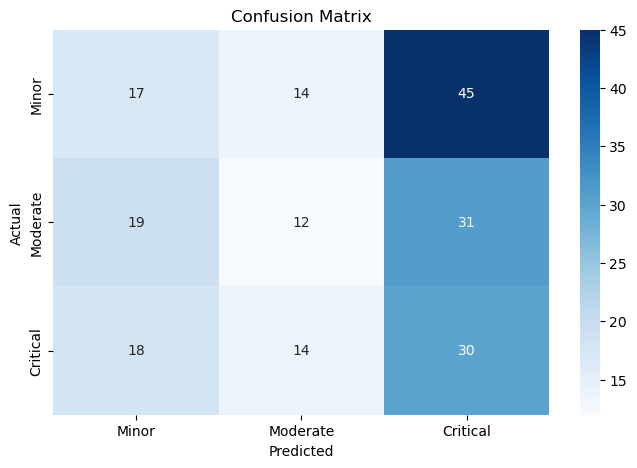

In [553]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 5))
class_labels = ['Minor', 'Moderate', 'Critical']
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()